In [1]:
import numpy as np
# import cv2
import tifffile as tiff
from shapely.geometry import Polygon, mapping, shape, box
from skimage import io
from skimage.measure import label, regionprops
import matplotlib.pyplot as plt
# import json
from rasterio import features
import scanpy as sc
import pandas as pd
import geopandas as gpd

import pickle
import scipy

from ast import literal_eval

import seaborn as sns

from SGanalysis.SGobject import SGobject
from adjustText import adjust_text

import matplotlib
%matplotlib inline
# matplotlib.use('Qt5Agg')
# %matplotlib qt

# import matplotlib as mpl
matplotlib.rcParams['pdf.fonttype'] = 42

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

plt.rcParams['font.size'] = 6  # Set default font size for all text elements
plt.rcParams['axes.labelsize'] = 8  # Set font size for axis labels
plt.rcParams['xtick.labelsize'] = 6  # Set font size for x-axis tick labels
plt.rcParams['ytick.labelsize'] = 6  # Set font size for y-axis tick labels
plt.rcParams['legend.fontsize'] = 6  # Set font size for legend text

from sklearn.cluster import AgglomerativeClustering as AggCluster

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import sys
import os

# tools_path  = '/Users/grantkinsler/Documents/Penn/Research/SpatialBarcodes/SpatialBarcodes/analysis/tools/tools.py'
tools_path = '../helperScripts/tools.py'
# tools_path  = '/Users/grantkinsler/Documents/Penn/Research/SpatialBarcodes/analysis/tools/tools.py'

# /Users/grantkinsler/Documents/Penn/Research/SpatialBarcodes/analysis/tools/tools.py
sys.path.append(os.path.dirname(os.path.expanduser(tools_path)))
import tools as tools

In [2]:
## load data for the roi of interest    
# roi_of_interest = 'roi_1' # Tumor Section 5
roi_of_interest = 'roi_2' # Tumor Section 1
# roi_of_interest  = 'roi_3' # Tumor Section 3
# roi_of_interest = 'run2_roi_2' # Tumor Section 2
# roi_of_interest = 'run2_roi_3' # Tumor Section 4

# # load the sg_object
# with open(f'{roi_file_paths[roi_of_interest]["out_path"]}/sg_object_dilate10_20240718.pkl', 'rb') as f:
#     sg_obj = pickle.load(f)

# load the dataframes with the cell by gene matrices, clustered and unclustered
unclustered_df =  pd.read_csv(f'{tools.roi_file_paths[roi_of_interest]["out_path"]}/cell_by_gene_matrix_dilate10_20240718_withbarcodes_atleast3.csv')
clustered_df = pd.read_csv(f'{tools.roi_file_paths[roi_of_interest]["out_path"]}/cell_by_gene_matrix_dilate10_20240718_withbarcodes_clustering_10bcs_0.4thresh.csv')



In [3]:
# merge the clustered and unclustered dataframes
cols_to_keep = ['object_id','bc_cluster','bc_cluster_n_bcs','bc_cluster_found_bcs','bc_cluster_bc_names']
df = unclustered_df.merge(clustered_df[cols_to_keep],on='object_id',how='left')   

In [4]:
gene_cols = [col for col in df.columns if 'bc_' not in col and col not in ['cell_id','object_id','area','called_barcodes','n_called_barcodes','barcode_names','area','center_x','center_y','nucleus','nucleus_centroid','nucleus_dilated']]    


In [5]:
### Functions to calculate gene expression statistics by groupings

# calculate the average of each gene in each group (e.g. spatial location or clone )
def grouped_obs_mean(adata, group_key, layer=None, gene_symbols=None):
    if layer is not None:
        getX = lambda x: x.layers[layer]
    else:
        getX = lambda x: x.X
    if gene_symbols is not None:
        new_idx = adata.var[idx]
    else:
        new_idx = adata.var_names

    grouped = adata.obs.groupby(group_key)
    out = pd.DataFrame(
        np.zeros((adata.shape[1], len(grouped)), dtype=np.float64),
        columns=list(grouped.groups.keys()),
        index=adata.var_names
    )

    for group, idx in grouped.indices.items():
        X = getX(adata[idx])
        out[group] = np.ravel(X.mean(axis=0, dtype=np.float64)).tolist()

    return out

# calculate the difference between maximum and minimum for each group from grouped_obs_mean
def group_delta_mean(adata, group_key, layer=None, gene_symbols=None):
    mean = grouped_obs_mean(adata, group_key, layer=layer, gene_symbols=gene_symbols)
    delta = mean.max(axis=1) - mean.min(axis=1)
    return delta

# perform permutations on the group identities and return the distribution of deltas for each gene
def permuted_group_delta_means(adata,group_key,n_perms=100, layer=None, gene_symbols=None):
    
    perms = []
    for perm in range(n_perms):
        permuted_clusters = adata.copy()
        permuted_clusters.obs[group_key] = np.random.permutation(adata.obs[group_key].values)
        gene_by_bc_cluster_mean_perm = group_delta_mean(permuted_clusters,group_key)
        perms.append(gene_by_bc_cluster_mean_perm)

    return perms

# calculate the empirical p-values for each gene
def calculate_empirical_p_values(real_values,permuted_values):
    p_values = []
    for gene in real_values.index:
        p_values.append((np.sum(permuted_values[gene] >= real_values[gene])+1)/(len(permuted_values[gene])+1))
        
    return pd.Series(p_values,index=real_values.index)

# calculate the score for each gene, which is the ratio of the real value to the mean of the permuted values
def calculate_group_scores(real_values,permuted_values):
    return real_values/np.mean(permuted_values,axis=0)



In [6]:

if roi_of_interest != 'roi_2':
    ring_annotated = pd.read_csv(f'../extractedData/in_vivo/other_rois/{roi_of_interest}_cell_by_gene_with_rings.csv',index_col=0)
else:
    # read the roi_2 from the original location
    ring_annotated = pd.read_csv(f'../extractedData/in_vivo/cell_by_gene_with_rings.csv',index_col=0)


In [7]:
ring_annotated

,object_id,AKT1,AXL,BGN,BIRC3,BIRC5,BMP2,BMP4,CALD1,CAPG,...,called_barcodes,n_called_barcodes,barcode_names,nucleus,nucleus_dilated,nucleus_centroid,center_x,center_y,area,Ring
0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,[],0,NaN,"POLYGON ((23727 1097, 23741 1098, 23776 1120, ...",POLYGON ((23723.19250194746 1087.7532190152529...,POINT (23747.879605737267 1155.8892298393657),23747.879606,1155.889230,12083.909039,NaN
1,10,1.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,1.0,...,"['bc_013', 'bc_060']",2,bc_013-bc_060,"POLYGON ((19439 1568, 19452 1569, 19459 1573, ...","POLYGON ((19435.37553738845 1558.679953284587,...",POINT (19439.586687306502 1590.1188510491918),19439.586687,1590.118851,3910.173214,2.0
2,100,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0,...,[],0,NaN,"POLYGON ((20345 1807, 20355 1818, 20349 1824, ...","POLYGON ((20339.70001059997 1798.520016959949,...",POINT (20308.01793721973 1845.0786338723558),20308.017937,1845.078634,6478.832120,2.0
3,1000,5.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,5.0,...,"['bc_068', 'bc_086']",2,bc_068-bc_086,"POLYGON ((10876 2957, 10910 2999, 10921 3005, ...","POLYGON ((10866.161300899 2955.211145618, 1086...",POINT (10900.868011182109 3028.338325346113),10900.868011,3028.338325,11563.956381,6.0
4,10000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4.0,0.0,...,"['bc_004', 'bc_033']",2,bc_004-bc_033,"POLYGON ((34221 9631, 34230 9631, 34242 9635, ...","POLYGON ((34216.77114534669 9621.938168600047,...",POINT (34222.068445056924 9672.302457590971),34222.068445,9672.302458,8075.173801,18.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64531,9994,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,[],0,NaN,"POLYGON ((10740 9628, 10759 9631, 10770 9642, ...",POLYGON ((10738.526886969112 9618.109098221183...,POINT (10723.83045958172 9671.305775912935),10723.830460,9671.305776,11130.640221,NaN
64532,9995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,[],0,NaN,"POLYGON ((24154 9628, 24163 9628, 24167 9637, ...","POLYGON ((24146 9622, 24140 9630, 24139.482983...",POINT (24164.804188342 9654.364679205015),24164.804188,9654.364679,2947.987326,24.0
64533,9996,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,...,"['bc_005', 'bc_030']",2,bc_005-bc_030,"POLYGON ((5129 9629, 5144 9639, 5157 9652, 516...","POLYGON ((5121.928932188134 9621.928932188135,...",POINT (5137.538336845518 9667.616847679257),5137.538337,9667.616848,5874.912824,2.0
64534,9998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,[],0,NaN,"POLYGON ((13878 9629, 13901 9632, 13921 9639, ...","POLYGON ((13871.753049524455 9621.19131190557,...",POINT (13913.352588747919 9668.934063821607),13913.352589,9668.934064,8293.379014,NaN


In [8]:
# df.sort_values('object_id',inplace=True)
# ring_annotated.sort_values('object_id',inplace=True)

df = df.merge(ring_annotated[['object_id','Ring']],on='object_id',how='left')

<AxesSubplot: xlabel='center_x', ylabel='center_y'>

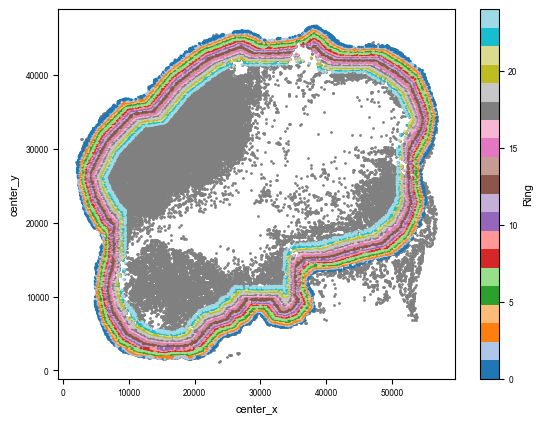

In [9]:
plt.figure()
ax = plt.gca()
df.plot.scatter(x='center_x',y='center_y',c='gray',s=1,ax=ax)


ring_annotated.plot.scatter(x='center_x',y='center_y',c='Ring',cmap='tab20',s=1,ax=ax)

In [10]:
## we can calculate the space scores only for barcoded cells
df_barcoded = df[df['bc_cluster'].notnull()]

for ring_partition,n_partitions in zip([ring_annotated],[25]):

    ring_partition = ring_partition[ring_partition['cell_id'].isin(df_barcoded['object_id'])]

    adata_genes_ring = sc.AnnData(ring_partition[[col for col in ring_partition.columns if col in gene_cols]])

    # assign erosion ring to each cell in obs according to the ring_annoted file
    adata_genes_ring.obs['erosion_ring'] = ring_partition['Ring'].values

        # calculate the statistics for clones
    real_delta_ring  = group_delta_mean(adata_genes_ring,'erosion_ring')
    perm_deltas_ring = permuted_group_delta_means(adata_genes_ring,'erosion_ring',n_perms=12000)
    # perm_deltas_ring = permuted_group_delta_means(adata_genes_ring,'erosion_ring',n_perms=1000)

    # calculate the scores and p-values for the clones
    scores_ring = calculate_group_scores(real_delta_ring,pd.DataFrame(perm_deltas_ring))
    p_vals_ring = calculate_empirical_p_values(real_delta_ring,pd.DataFrame(perm_deltas_ring))


    space_score_df = pd.DataFrame({'gene':scores_ring.index,'score':scores_ring,'p_val':p_vals_ring})

    if roi_of_interest != 'roi_2':
        space_score_df.to_csv(f'../extractedData/in_vivo/other_rois/space_scores_{roi_of_interest}_{n_partitions}rings_barcoded.csv',index=False)
    else:
        space_score_df.to_csv(f'../extractedData/in_vivo/space_scores_{n_partitions}rings_barcoded.csv',index=False)

/var/folders/x6/q0wb9df97nj1wnk5c4t0k7840000gn/T/ipykernel_26167/4017029744.py:8: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_genes_ring = sc.AnnData(ring_partition[[col for col in ring_partition.columns if col in gene_cols]])
/Users/grantkinsler/opt/miniconda3/envs/spatialgenomics-env2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [ ]:
scores_ring.sort_values(ascending=False).head(10)

NFATC2    5.742185
MITF      5.029064
CTNNB1    4.668827
ITGA6     4.599635
FOSB      4.493525
SNAI2     4.371142
MYBL2     4.093535
BIRC5     4.017067
SPARC     3.811218
MLANA     3.692965
dtype: float64

In [ ]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

VEGFA max_location 341.46000000000004
VEGFA max 4.555555555555555
VEGFA min 0.48554913294797686
VEGFA max/min 9.382275132275133
MITF max_location 37.94
MITF max 6.068004459308807
MITF min 1.6781354051054385
MITF max/min 3.6159206467177483


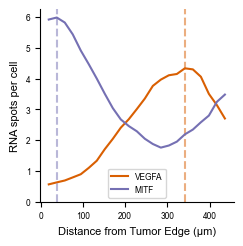

In [ ]:
plt.figure(figsize=(2.5,2.5))
means_ring = grouped_obs_mean(adata_genes_ring,'erosion_ring')

# genes_to_show = ['VEGFA','MITF','SFRP1','SPARC']
genes_to_show = ['VEGFA','MITF']

window_size =3

gene_colors = {
                # 'VEGFA':'#5e3c99',
               'VEGFA':'#d95f02',
               
            #    'MITF':'#e66101',
               'MITF':'#7570b3',
               
               }
for gene in genes_to_show:
    # plt.plot(means_ring.loc[gene],label=gene,color=colors[gene])
    # plt.plot(moving_average((means_ring.loc[gene]/np.sum(means_ring.loc[gene])).values,3),label=gene,color=colors[genes_to_show.index(gene)])

    width = 18.97
    x_space = [x*width for x in range(len(means_ring.loc[gene]))]




    plt.plot(moving_average(x_space,window_size),moving_average((means_ring.loc[gene]).values,window_size),label=gene,color=gene_colors[gene])

    max_idx = np.argmax(moving_average((means_ring.loc[gene]).values,window_size))
    plt.axvline(x=moving_average(x_space,window_size)[max_idx],color=gene_colors[gene],linestyle='--',alpha=0.5)
    
    print(gene,'max_location',moving_average(x_space,window_size)[max_idx])
    print(gene,'max',np.max(means_ring.loc[gene]))
    print(gene,'min',np.min(means_ring.loc[gene]))
    print(gene,'max/min',np.max(means_ring.loc[gene])/np.min(means_ring.loc[gene]))

    

plt.legend()
plt.xlabel('Distance from Tumor Edge (µm)')
plt.ylabel('RNA spots per cell')

plt.yticks(range(7),range(7))
# plt.xticks(ran)



# remove top and right spines
sns.despine()

if roi_of_interest != 'roi_2':
    plt.savefig('../graphs/other_rois/{roi_of_interest}_genes_vs_distance_25rings_barcode_VEGFA_MITF.pdf',transparent=True,bbox_inches='tight')
else:
    plt.savefig('../graphs/genes_vs_distance_25rings_barcode_VEGFA_MITF.pdf',transparent=True,bbox_inches='tight')
